In [1]:
from batchcreator import DataGenerator, get_list_IDs
from datetime import datetime
import tensorflow as tf
from model_builder import build_generator, GAN
import numpy as np

import matplotlib.pyplot as plt
import logger

import wandb
from wandb.keras import WandbCallback

In [13]:
run = wandb.init(project='precipitation-forecasting',
                config={
                    'batch_size': 1,
                    'epochs': 10,
                    'lr_g': 0.0001,
                    'lr_d': 0.0001,
                    'x_length': 6,
                    'y_length': 1,
                    'rnn_type': 'GRU',
                    'filter_no_rain': True,
                    'architecture': 'AENN',
                    'norm_method': None,
                    'l_g': 0.06,
                    'l_mse': 1
                })
config = wandb.config

In [3]:
start_dt = datetime(2019,6,6,0,0)
end_dt =  datetime(2019,6,8,1,0)

list_IDs = get_list_IDs(start_dt, end_dt, config.x_length, config.y_length, filter_no_rain=config.filter_no_rain)
print(list_IDs[-1])
print(len(list_IDs))

(['201906080000', '201906080005', '201906080010', '201906080015', '201906080020', '201906080025'], ['201906080030'])
76


In [4]:
same_data = [list_IDs[0] for i in range(0, 128)]
# same_data = [list_IDs[0],  list_IDs[0], list_IDs[0], list_IDs[0], list_IDs[0], list_IDs[0], list_IDs[0], list_IDs[0]]
print(same_data[0])
print(len(same_data))

(['201906052330', '201906052335', '201906052340', '201906052345', '201906052350', '201906052355'], ['201906060000'])
128


In [5]:
model = GAN(rnn_type=config.rnn_type, x_length=config.x_length, 
            y_length=config.y_length, architecture=config.architecture, relu_alpha=.2,
           l_g = config.l_g, l_mse = config.l_mse)
model.compile(lr_g=config.lr_g, lr_d=config.lr_d)

In [6]:
model.generator.summary()

Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 6, 768, 700, 1)]  0         
_________________________________________________________________
zero_padding3d (ZeroPadding3 (None, 6, 768, 768, 1)    0         
_________________________________________________________________
conv2d (Conv2D)              (None, 6, 384, 384, 32)   832       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 6, 384, 384, 32)   0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 128, 128, 32)   25632     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 6, 128, 128, 32)   0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 64, 64, 64)     18

In [10]:
# # val data:
# start_dt = datetime(2019,6,5,0,0)
# end_dt =  datetime(2019,6,8,1,0)

# list_IDs = get_list_IDs(start_dt, end_dt, config.x_length, config.y_length, 
#                         filter_no_rain=config.filter_no_rain)

generator_val = DataGenerator(list_IDs[:8], batch_size=config.batch_size, x_seq_size=config.x_length, 
                                       y_seq_size=config.y_length, norm_method=config.norm_method, load_from_npy=True)

x_test = []
y_test = []

for xs, ys in generator_val:
    x_test.extend(xs)
    y_test.extend(ys)
x_test = np.array(x_test)
y_test = np.array(y_test)
# x_test = tf.convert_to_tensor(x_test)
# y_test = tf.convert_to_tensor(y_test)
print(x_test.shape)
print(y_test.shape)

(8, 6, 768, 700, 1)
(8, 1, 384, 350, 1)


In [14]:
model = build_generator(architecture='AENN', rnn_type='GRU', relu_alpha=0.2)
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='mse', metrics=['mse', 'mae'])

In [ ]:
generator = DataGenerator(list_IDs, batch_size=1, x_seq_size=config.x_length, 
                                       y_seq_size=config.y_length, norm_method=config.norm_method, load_from_npy=True)
wandb_callback = wandb.keras.WandbCallback()

hist = model.fit(generator, epochs=50, 
                 callbacks=[wandb_callback, 
                          #  logger.GradientLogger(x_test,y_test), 
                            logger.ImageLogger(x_test,y_test)
                           ])

Epoch 1/50
76/76 [==============================] - 31s 407ms/step - loss: 27.7332 - mse: 27.7332 - mae: 0.7178
Epoch 2/50
76/76 [==============================] - 31s 410ms/step - loss: 26.4639 - mse: 26.4639 - mae: 0.7208
Epoch 3/50
76/76 [==============================] - 32s 414ms/step - loss: 24.3607 - mse: 24.3607 - mae: 0.6809
Epoch 4/50
76/76 [==============================] - 31s 414ms/step - loss: 26.6739 - mse: 26.6739 - mae: 0.6985
Epoch 5/50
76/76 [==============================] - 32s 414ms/step - loss: 25.4764 - mse: 25.4764 - mae: 0.6921
Epoch 6/50
76/76 [==============================] - 32s 415ms/step - loss: 25.7297 - mse: 25.7297 - mae: 0.6999
Epoch 7/50
76/76 [==============================] - 31s 414ms/step - loss: 24.7049 - mse: 24.7049 - mae: 0.6818
Epoch 8/50
76/76 [==============================] - 31s 414ms/step - loss: 27.0332 - mse: 27.0333 - mae: 0.7111
Epoch 9/50
76/76 [==============================] - 31s 413ms/step - loss: 24.0465 - mse: 24.0465 - mae:

In [23]:
xs_in = []
ys_out = []
for xs,ys in generator:
   # print(xs.shape, ys.shape)
    xs_in.append(xs)
    ys_out.append(ys)
ys_out = np.array(ys_out)
xs_in = np.array(xs_in)

print(xs_in.shape)
print(ys_out.shape)

(76, 1, 6, 768, 700, 1)
(76, 1, 1, 384, 350, 1)


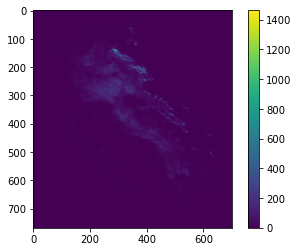

In [24]:
plt.imshow(np.squeeze(xs_in[0][0][-1]))
plt.colorbar()

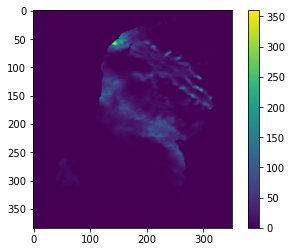

In [25]:
plt.imshow(np.squeeze(ys_out[0][0]))
plt.colorbar()

(1, 1, 384, 350, 1)


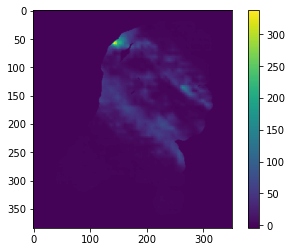

In [26]:
out = model.predict(xs_in[0])
print(out.shape)
plt.imshow(np.squeeze(out[0]))
plt.colorbar()

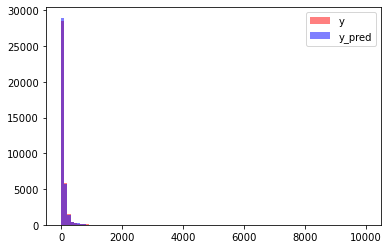

In [23]:
bins = np.linspace(1, 10000, 100)

y = np.squeeze(ys[0]).flatten()
y_pred = np.squeeze(out[0]).flatten()
plt.hist(y, bins, alpha=0.5, label='y', color='r')
plt.hist(y_pred, bins, alpha=0.5, label='y_pred', color='b')
plt.legend(loc='upper right')
plt.show()

In [ ]:
np.unique(out[0])

In [ ]:
out = model.predict(xs_in[0])
out.shape

In [ ]:
plt.imshow(np.squeeze(out[0]))
plt.colorbar()

In [12]:
run.finish()

In [ ]:
model.save("gan_model")

In [ ]:
model.generator.save("generator")

In [ ]:
# Test generator
start_dt = datetime(2019,6,6,0,0)
end_dt =  datetime(2019,6,6,0,5)

list_IDs = get_list_IDs(start_dt, end_dt, x_seq_size, y_seq_size, filter_no_rain=filter_no_rain)
generator = DataGenerator(list_IDs, batch_size=1, x_seq_size=x_seq_size, 
                                       y_seq_size=y_seq_size, normalize_y=False)
for i in generator:
    x,y = i
    print(x.shape, y.shape)

In [ ]:
y_pred = model.generator(x)
y_pred.shape

In [ ]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(np.squeeze(y))
plt.colorbar()
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(np.squeeze(y_pred))
plt.colorbar()
plt.show()

In [ ]:
plt.hist(y_pred.numpy().flatten())

In [ ]:
model.discriminator(y_pred)